<a href="https://colab.research.google.com/github/ysmnpksy/Final-Project/blob/main/Set3_Transformer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Transformer Models</h1>


# Loading the Data

In [ ]:
! pip install datasets
! pip install transformers

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yasminpaksoy","key":"9092d77ded0787db0dc92dec0c6c058c"}'}

In [ ]:
# making kaggle directory 
! mkdir ~/.kaggle

# copying api login info into directory 
! cp kaggle.json ~/.kaggle/

# allocating required permissions 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rmisra/imdb-spoiler-dataset

# unzipping dataset 
! unzip imdb-spoiler-dataset.zip

 99% 329M/331M [00:02<00:00, 146MB/s]
100% 331M/331M [00:02<00:00, 165MB/s]
Archive:  imdb-spoiler-dataset.zip
  inflating: IMDB_movie_details.json  
  inflating: IMDB_reviews.json       


# Preparing the Data <a class="anchor" id="preparing"></a>

In [ ]:
from datasets import load_dataset
dataset = load_dataset('json', data_files='IMDB_reviews.json')

Using custom data configuration default-26625881577fe713


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-26625881577fe713/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset = dataset['train']

In [ ]:
from datasets import Dataset, DatasetDict
train_testvalid = dataset.train_test_split(test_size=500) # splitting into train and test
train_discard = train_testvalid['train'].train_test_split(train_size=1000) # further splitting train into train and discarding the rest 
test_valid = train_testvalid["test"].train_test_split(test_size=250) # further splitting test into validation and test
datasets = DatasetDict({"train": train_discard["train"], "test": test_valid["train"], "valid": test_valid["test"]}) # creating huggingface dataset

In [ ]:
datasets # checking output looks correct

DatasetDict({
    train: Dataset({
        features: ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary'],
        num_rows: 250
    })
    valid: Dataset({
        features: ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary'],
        num_rows: 250
    })
})

In [ ]:
datasets = datasets.remove_columns(column_names = ['review_date', 'movie_id', 'user_id', 'rating', 'review_summary']) # removing irrelevent columns

In [ ]:
datasets # checking dataset again

DatasetDict({
    train: Dataset({
        features: ['is_spoiler', 'review_text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['is_spoiler', 'review_text'],
        num_rows: 250
    })
    valid: Dataset({
        features: ['is_spoiler', 'review_text'],
        num_rows: 250
    })
})

In [ ]:
datasets["train"].features # checking types of features

{'is_spoiler': Value(dtype='bool', id=None),
 'review_text': Value(dtype='string', id=None)}

In [ ]:
# casting boolean into ints for training later on
from datasets import Value
datasets["train"] = datasets["train"].cast_column('is_spoiler', Value('int64'))
datasets["valid"] = datasets["valid"].cast_column('is_spoiler', Value('int64'))
datasets["test"] = datasets["test"].cast_column('is_spoiler', Value('int64'))

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
datasets["train"].features

{'is_spoiler': Value(dtype='int64', id=None),
 'review_text': Value(dtype='string', id=None)}

In [ ]:
datasets["valid"].features

{'is_spoiler': Value(dtype='int64', id=None),
 'review_text': Value(dtype='string', id=None)}

In [ ]:
datasets["test"].features

{'is_spoiler': Value(dtype='int64', id=None),
 'review_text': Value(dtype='string', id=None)}

## Checking Train for Imbalance

In [ ]:
# casting to pandas DataFrame
import pandas as pd
datasets.set_format(type="pandas")
trainDF = datasets["train"][:]
trainDF.head()

,is_spoiler,review_text
0,1,"First I would like to say that I felt the ""Cha..."
1,0,It was disgustingly tempting to give this movi...
2,0,"This movie has a great production, filming, be..."
3,0,"Yes, it sounds like a weird combination. A sub..."
4,0,"This is not a bad film, just not a great film...."


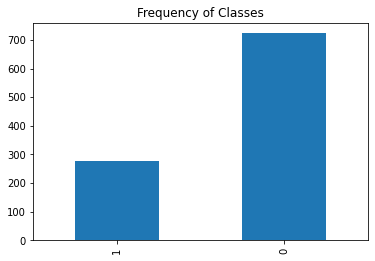

In [ ]:
# checking imbalance via graph
import matplotlib.pyplot as plt
trainDF["is_spoiler"].value_counts(ascending=True).plot.bar()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
# balancing via undersampling
import numpy as np
from imblearn.under_sampling import RandomUnderSampler 

x = trainDF["review_text"].to_numpy()
x = x.reshape(-1, 1)
y = trainDF["is_spoiler"].to_numpy()
y = y.reshape(-1, 1)
rus = RandomUnderSampler()
x, y = rus.fit_resample(x, y)

In [ ]:
trainDF = pd.DataFrame({'is_spoiler': y, 'review_text': x.flatten()}, columns=['is_spoiler', 'review_text']) # new balancd DataFrame

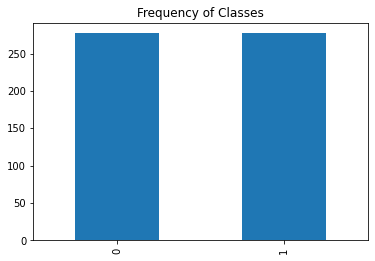

In [ ]:
# checking imbalance
trainDF["is_spoiler"].value_counts(ascending=True).plot.bar()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
len(trainDF) # length of new train dataset

554

In [ ]:
datasets["train"] = Dataset.from_pandas(trainDF) # converting dataframe back to dataset

## Hugging Face Format

In [ ]:
datasets.reset_format() # reset from pandas 

In [ ]:
datasets = datasets.rename_column("is_spoiler", "labels") # rename label column

In [ ]:
datasets["train"]

Dataset({
    features: ['labels', 'review_text'],
    num_rows: 554
})

In [ ]:
datasets["valid"]

Dataset({
    features: ['labels', 'review_text'],
    num_rows: 250
})

In [ ]:
datasets["test"]

Dataset({
    features: ['labels', 'review_text'],
    num_rows: 250
})

# Tokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["review_text"], padding=True, truncation=True)

In [ ]:
encoded_datasets = datasets.map(preprocess_function, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# checking new columns
print(encoded_datasets["train"].column_names)

['labels', 'review_text', 'input_ids', 'attention_mask']


# Models

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
num_labels = 2
batch_size = 64
model_name = "name"
logging_steps = len(encoded_datasets["train"]) // batch_size

In [ ]:
# getting metrics ready
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
def metrics(pred):
  zero_division = 0
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)
  accuracy = accuracy_score(labels, preds)
  recall = recall_score(labels, preds)
  precision = precision_score(labels, preds)
  f1 = f1_score(labels, preds)
  return {"accuracy":accuracy, "recall":recall, "precision":precision, "f1":f1}

In [ ]:
def train_model(model):
  trainer = Trainer(model=model,
                    args=train_args,
                    compute_metrics=metrics,
                    train_dataset=encoded_datasets["train"],
                    eval_dataset=encoded_datasets["valid"],
                    tokenizer=tokenizer
                    )
  return trainer.train()

## Model 1: Initial Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_labels)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-5,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.01,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.690300,0.685966,0.556000,0.825397,0.342105,0.483721
2,0.674100,0.674988,0.584000,0.793651,0.354610,0.490196
3,0.656200,0.581263,0.760000,0.507937,0.524590,0.516129
4,0.614900,0.655422,0.640000,0.793651,0.393701,0.526316
5,0.585800,0.564331,0.724000,0.666667,0.466667,0.549020
6,0.554000,0.551607,0.724000,0.603175,0.463415,0.524138
7,0.505000,0.651649,0.636000,0.777778,0.388889,0.518519
8,0.462600,0.545436,0.724000,0.555556,0.460526,0.503597
9,0.429900,0.596640,0.700000,0.682540,0.438776,0.534161
10,0.404000,0.598151,0.700000,0.682540,0.438776,0.534161


## Tuning Learning Rate

### Model 2: Learning Rate 2e-6

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-6,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.01,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.693600,0.698382,0.392000,0.913043,0.301435,0.453237
2,0.692900,0.698061,0.400000,0.927536,0.306220,0.460432
3,0.693100,0.695239,0.452000,0.884058,0.321053,0.471042
4,0.685500,0.695390,0.448000,0.898551,0.321244,0.473282
5,0.687200,0.692984,0.476000,0.869565,0.329670,0.478088
6,0.685000,0.692614,0.488000,0.869565,0.335196,0.483871
7,0.680500,0.691867,0.496000,0.869565,0.338983,0.487805
8,0.685900,0.691740,0.492000,0.869565,0.337079,0.485830
9,0.683500,0.691384,0.492000,0.869565,0.337079,0.485830
10,0.683500,0.691237,0.496000,0.869565,0.338983,0.487805


### Model 3: Learning Rate 2e-4

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_labels)

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-4,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.01,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.707900,0.672339,0.740000,0.072464,0.833333,0.133333
2,0.689300,0.683495,0.476000,0.927536,0.336842,0.494208
3,0.631700,0.646755,0.572000,0.884058,0.381250,0.532751
4,0.539200,0.536840,0.644000,0.782609,0.421875,0.548223
5,0.556700,0.831954,0.600000,0.811594,0.391608,0.528302
6,0.427000,1.110767,0.572000,0.797101,0.371622,0.506912
7,0.252400,0.926237,0.692000,0.463768,0.444444,0.453901
8,0.101300,0.986084,0.692000,0.463768,0.444444,0.453901
9,0.044300,1.250778,0.652000,0.536232,0.402174,0.459627
10,0.021900,1.251190,0.684000,0.420290,0.426471,0.423358


## Tuning Weight Decay

### Model 4: Weight Decay 0.04

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_labels)

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-4,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.04,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.708500,0.681746,0.556000,0.760563,0.364865,0.493151
2,0.660300,0.642788,0.580000,0.788732,0.383562,0.516129
3,0.606500,0.535894,0.756000,0.436620,0.596154,0.504065
4,0.572600,0.635883,0.640000,0.690141,0.418803,0.521277
5,0.500300,1.342482,0.452000,0.873239,0.326316,0.475096
6,0.508700,0.602628,0.720000,0.605634,0.505882,0.551282
7,0.473800,0.846239,0.720000,0.619718,0.505747,0.556962
8,0.182500,1.124780,0.620000,0.774648,0.410448,0.536585
9,0.146100,0.740015,0.756000,0.535211,0.575758,0.554745
10,0.194500,0.838702,0.736000,0.605634,0.530864,0.565789


### Model 5: Weight Decay 0.08

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_labels)

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-4,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.02,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.714900,0.649887,0.748000,0.000000,0.000000,0.000000
2,0.678300,0.663792,0.716000,0.158730,0.357143,0.219780
3,0.682700,0.639513,0.644000,0.682540,0.383929,0.491429
4,0.670900,0.565342,0.752000,0.428571,0.509434,0.465517
5,0.581000,0.690596,0.632000,0.650794,0.369369,0.471264
6,0.461400,1.093322,0.560000,0.841270,0.346405,0.490741
7,0.249100,0.745153,0.684000,0.492063,0.397436,0.439716
8,0.164600,0.963204,0.628000,0.698413,0.372881,0.486188
9,0.085400,1.109534,0.632000,0.650794,0.369369,0.471264
10,0.044100,1.319980,0.608000,0.698413,0.357724,0.473118


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Dropout

In [ ]:
from transformers import DistilBertConfig

In [ ]:
train_args = TrainingArguments(num_train_epochs=10, 
                               output_dir=model_name,
                               learning_rate=2e-4,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.02,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

### Model 6: 20%

In [ ]:
config = DistilBertConfig(dropout=0.2,
                          attention_dropout=0.2)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.725800,0.660403,0.748000,0.000000,0.000000,0.000000
2,0.682300,0.677757,0.660000,0.825397,0.412698,0.550265
3,0.659700,0.532959,0.728000,0.523810,0.464789,0.492537
4,0.619800,0.566074,0.716000,0.507937,0.444444,0.474074
5,0.443300,0.629145,0.700000,0.571429,0.428571,0.489796
6,0.430100,0.604703,0.736000,0.412698,0.472727,0.440678
7,0.318300,1.292567,0.548000,0.793651,0.333333,0.469484
8,0.192300,0.855883,0.720000,0.539683,0.453333,0.492754
9,0.101700,1.223539,0.628000,0.682540,0.370690,0.480447
10,0.093800,1.184582,0.652000,0.650794,0.386792,0.485207


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 7: 30%

In [ ]:
config = DistilBertConfig(dropout=0.3,
                          attention_dropout=0.3)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.706100,0.742532,0.284000,1.000000,0.284000,0.442368
2,0.696100,0.674490,0.720000,0.028169,0.666667,0.054054
3,0.692900,0.691121,0.540000,0.774648,0.357143,0.488889
4,0.680200,0.729027,0.604000,0.704225,0.390625,0.502513
5,0.653600,0.856912,0.504000,0.774648,0.337423,0.470085
6,0.584700,0.754535,0.528000,0.704225,0.340136,0.458716
7,0.521600,0.825264,0.620000,0.647887,0.396552,0.491979
8,0.313400,1.379924,0.528000,0.774648,0.350318,0.482456
9,0.299800,1.217356,0.560000,0.704225,0.359712,0.476190
10,0.206000,1.296479,0.548000,0.718310,0.354167,0.474419


## Number of Layers

Default: 6

### Model 8: 10 Layers

In [ ]:
config = DistilBertConfig(dropout=0.2,
                          attention_dropout=0.2,
                          n_layers = 10)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.831400,0.762255,0.284000,1.000000,0.284000,0.442368
2,0.701400,0.843346,0.464000,0.859155,0.329730,0.476563
3,0.688600,0.689032,0.592000,0.704225,0.381679,0.495050
4,0.673200,0.579294,0.676000,0.507042,0.439024,0.470588
5,0.642600,0.633940,0.632000,0.647887,0.407080,0.500000
6,0.576000,0.735334,0.660000,0.591549,0.428571,0.497041
7,0.458600,0.851364,0.580000,0.492958,0.336538,0.400000
8,0.294900,0.988496,0.560000,0.661972,0.353383,0.460784
9,0.227400,1.108227,0.540000,0.661972,0.340580,0.449761
10,0.167800,1.076251,0.588000,0.563380,0.357143,0.437158


### Model 9: 8 Layers

In [ ]:
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          n_layers = 8)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.7.attention.v_lin.weight'

In [ ]:
trainer = train_model(model)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.763300,0.692859,0.560000,0.876923,0.358491,0.508929
2,0.702000,0.559336,0.744000,0.015385,1.000000,0.030303
3,0.670400,0.536364,0.696000,0.507692,0.428571,0.464789
4,0.559900,0.680211,0.744000,0.030769,0.666667,0.058824
5,0.795200,0.560393,0.732000,0.323077,0.477273,0.385321
6,0.472800,0.759089,0.724000,0.369231,0.461538,0.410256
7,0.420600,0.913932,0.584000,0.630769,0.338843,0.440860
8,0.196400,1.287967,0.520000,0.723077,0.315436,0.439252
9,0.164000,1.176983,0.616000,0.523077,0.343434,0.414634
10,0.087400,1.329993,0.596000,0.584615,0.339286,0.429379


# Training Final Model

In [ ]:
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          n_layers = 6)

In [ ]:
train_args = TrainingArguments(num_train_epochs=3, 
                               output_dir=model_name,
                               learning_rate=2e-4,
                               per_device_train_batch_size=batch_size,
                               per_device_eval_batch_size=batch_size,
                               weight_decay=0.02,
                               evaluation_strategy="epoch",
                               disable_tqdm=False,
                               logging_steps=logging_steps,
                               log_level="error")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config = config)

In [ ]:
trainer = Trainer(model=model,
                  args=train_args,
                  compute_metrics=metrics,
                  train_dataset=encoded_datasets["train"],
                  eval_dataset=encoded_datasets["valid"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.704400,0.743731,0.256000,1.000000,0.256000,0.407643
2,0.696500,0.664154,0.740000,0.078125,0.454545,0.133333
3,0.687200,0.713671,0.556000,0.765625,0.337931,0.468900


TrainOutput(global_step=27, training_loss=0.6930700408087836, metrics={'train_runtime': 425.3645, 'train_samples_per_second': 3.907, 'train_steps_per_second': 0.063, 'total_flos': 220160816566272.0, 'train_loss': 0.6930700408087836, 'epoch': 3.0})

In [ ]:
preds = trainer.predict(encoded_datasets["test"])

In [ ]:
y_pred = np.argmax(preds.predictions, axis=-1)

In [ ]:
print('Accuracy: %.2f' % (accuracy_score(preds.label_ids, y_pred)))
print('Precision score: %.2f' % (precision_score(preds.label_ids, y_pred)))
print('Recall score: %.2f' % (recall_score(preds.label_ids, y_pred)))
print('F1 score: %.2f' % (f1_score(preds.label_ids, y_pred)))

Accuracy: 0.56
Precision score: 0.34
Recall score: 0.74
F1 score: 0.47
